In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import sys

In [2]:
import numpy as np
from shutil import copyfile
import matplotlib.pyplot as plt
import sys, os
import dill
sys.path.append('../')
import mg_si
import csv
import datetime
from mg_si import plot as mplt

import signal

class timeout:
    def __init__(self, seconds=1, error_message=None):
        self.seconds = seconds
        if error_message is None:
        	self.error_message = 'solution timed out after {}s'.format(seconds)
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

In [51]:
r_i_real = 1220e3

layer_thickness = 100 # m
overturn = 600 # Myr
times = np.linspace(0,4568e6*365.25*24*3600,40000)

## background mantle state
MgNumFp = 0.8
MgNumPv = 0.93
X_MgFeO_b = 0.311
X_SiO2_b = 0.015
## Mantle viscosity
pl = mg_si.planet.Custom()
nu_present = 10**21/pl.params.mantle.rho #[m^2/s]

T_min_all = 4900
# T_max_all = 6000
T_max_all = 5600
dT = 100

dMg = .01
minMg = 1e-5
maxMg = .1

dO = .01
minO = 1e-5
# maxO = .4
maxO = .25

dSi = .01
minSi = 1e-5
# maxSi = .4
maxSi = .25

T_cmbs = np.linspace(T_min_all,T_max_all,round((T_max_all-T_min_all)/dT)+1)
X_Mgs = np.linspace(minMg,maxMg, round((maxMg-minMg)/dMg)+1)
X_Sis = np.linspace(minSi, maxSi, round((maxSi-minSi)/dSi)+1)
X_Os = np.linspace(minO, maxO, round((maxO-minO)/dO)+1)

vectors = [T_cmbs,X_Mgs,X_Sis,X_Os]

basefolder = '/media/nknezek/compute_storage/explore_space_test/'
alldatafile = 'all_parameters.m'

Ntotal = len(T_cmbs)*len(X_Mgs)*len(X_Sis)*len(X_Os)
i = 1
def compute_one_run(x,iT): 
    T_cmb0 = T_cmbs[x[0]] 
    X_Mg_0 = X_Mgs[x[1]]
    X_Si_0 = X_Sis[x[2]]
    X_O_0 = X_Os[x[3]]
    times = np.linspace(0,4568e6*365.25*24*3600,40000)

    time = str(datetime.datetime.now())
    print('{} - {:.0f}K - {:.3f}Mg {:.3f}Si {:.3f}O'.format(time, T_cmb0, X_Mg_0, X_Si_0, X_O_0))
    pl = mg_si.planet.Custom()
    pl.reactions._set_layer_thickness(layer_thickness)
    pl.reactions._set_overturn_time(overturn)
    deltaT0 = pl.mantle_layer.get_dT0(T_cmb0)
    T_um0 = T_cmb0-deltaT0
    try:
        filepath = basefolder+ "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(T_cmb0, X_Mg_0, X_Si_0, X_O_0)
        if not os.path.exists(basefolder):
            os.mkdir(basefolder)
        if os.path.exists(filepath+'r_i.m'):
            print('r_i already computed')
            r_i = dill.load(open(filepath+'r_i.m','rb'))
            return r_i
        if os.path.exists(filepath+'data.m'):
            print('already computed')
            try:
                pl,times,solution = dill.load(open(filepath+'data.m','rb'))
                r_i = pl.core_layer.r_i(solution[-1,0], one_off=True)
                dill.dump(r_i, open(filepath+'r_i.m','wb'))
                del pl
                return r_i
            except:
                print('could not load previously computed solution, re-computing now')
        if not os.path.exists(filepath):
            os.mkdir(filepath)
    except:
        print('!!!!! Problem setting up folders',sys.exc_info()[1])
        del pl
        return np.nan
    try:
        pl.params.reactions.ParamCitationFeO = 'Fischer2015'
        pl.params.reactions.ParamCitationSiO2 = 'Fischer2015'
        pl.params.reactions.ParamCitationMgO = 'Badro2015'

        Moles_0 = pl.reactions.compute_Moles_0(X_Mg_0, X_Si_0, X_O_0, T_cmb0)
        x0 = [T_cmb0, T_um0]
        x0 = x0+Moles_0
        pl.params.reactions.Moles_0 = Moles_0
        Mm_b = pl.reactions.mantle.compute_Mm_b(X_MgFeO=X_MgFeO_b, X_SiO2=X_SiO2_b, MgNumFp=MgNumFp, MgNumPv=MgNumPv)
        pl.params.reactions.Mm_b = Mm_b
    except:
        print('Problem with initial mole 0',sys.exc_info()[1])
        del pl
        return np.nan
    try:
        T_present = 1350 # [K]
        nu_old =  nu_present/1e3
        T_old = T_um0
        A,nu0 = pl.mantle_layer.find_arrenhius_params(nu_present, T_present, nu_old, T_old, set_values=True)
    except:
        print('!!!!! Problem setting viscosity',sys.exc_info()[1])
        del pl
        return np.nan
    # plot and store solution info
    timeoutsecs = 120
    try:
        with timeout(seconds=timeoutsecs):
            solution = pl.integrate(times, x0)	
    except TimeoutError as err:
        print('!!!!!!',err,'with {} timesteps'.format(len(times)))
        return np.nan
    except:
        print("!!!!!! Unexpected error during solution:",sys.exc_info()[1])
        return np.nan
    try:
        r_i = pl.core_layer.r_i(solution[-1,0], one_off=True)
    except:
        print('!!!!! Problem computing r_i',sys.exc_info()[1])
        del pl
        return np.nan
    try:
        dill.dump(r_i, open(filepath+'r_i.m','wb'))
        dill.dump((pl, times, solution), open(filepath+'data.m','wb'))
    except:
        print('!!!!! Problem saving solution',sys.exc_info()[1])
        del pl
        return r_i
    try:
        # if the inner-core size is within 10% of real inner-core, compute entropy and heat terms
        if np.abs(r_i/r_i_real-1)<.1:
            print('r_i {:.0f} km within 10%, computing and storing entropy history'.format(r_i/1e3))
            t_N, all_parameters = pl.core_layer.compute_all_parameters(times, solution)
#             mplt.Q_all(pl, t_N, all_parameters, filepath=filepath)
            mplt.E_all(pl, t_N, all_parameters, filepath=filepath)
            dill.dump((t_N, all_parameters), open(filepath+alldatafile,'wb'))
            plt.close('all')
        else:
            print('r_i {:.0f} km not within 10%, entropies not computed'.format(r_i/1e3))
        del pl
        print('==== successfully finished computing')
        return r_i
    except:
        print('!!!!! Problem computing entropies',sys.exc_info()[1])
        return r_i

In [52]:
def inspace(x):
    for xd,vec in zip(x,vectors):
        if xd >len(vec)-1 or xd<0:
            return False
    return True
        

In [5]:
x0 = [10,1,1,1]
inspace(x0)

True

In [6]:
x0 = [10,1,1,1]
r_i = compute_one_run(x0,0)
r_i/1e3

2018-04-29 17:11:17.073540 - 5900K - 0.010Mg 0.010Si 0.010O
r_i already computed


1712.18248531909

In [53]:
def isvalid(x,dim=0):
    r_i_real = 1220e3
    r_i = compute_one_run(x,dim)
    return np.abs(r_i/r_i_real-1)<.1

In [8]:
isvalid(x0,0)

2018-04-29 17:11:18.557270 - 5900K - 0.010Mg 0.010Si 0.010O
r_i already computed


False

# Collect Valid Results already computed

In [3]:
import pandas as pd

In [5]:
# datadir = '/media/nknezek/compute_storage/computed_solutions_Fischer2015/'
# testdir = '/media/nknezek/compute_storage/explore_space_test/'
testdir = '/media/nknezek/compute_storage/computed_solutions_nature/'
datadir = '/media/nknezek/compute_storage/computed_solutions_nature/'

all_data = csv.writer(open(testdir+'all_data.csv','w'))
ri10p_data = csv.writer(open(testdir+'ri10p_data.csv','w'))

for i in [0,1,2,3]:
    reader = csv.reader(open(datadir+'run_data{}.csv'.format(i),'r'))
    for row in reader:
        all_data.writerow(row)
        if np.abs(float(row[1])/1220e3-1) < 0.10:
            ri10p_data.writerow(row)

In [9]:
df10 = pd.read_csv(datadir+'ri10p_data.csv',names=['time', 'r_i', 'T_cmb0', 'X_Mg_0', 'X_Si_0', 'X_O_0', 'MgNumFp', 'MgNumPv', 'X_MgFeO_b', 'X_SiO2_b', 'nu_present', 'deltaT0', 'layer_thickness', 'overturn'])
df10.describe()

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0,MgNumFp,MgNumPv,X_MgFeO_b,X_SiO2_b,nu_present,deltaT0,layer_thickness,overturn
count,1.245000e+03,1245.000000,1245.000000,1245.000000,1245.000000,1.245000e+03,1.245000e+03,1.245000e+03,1.245000e+03,1.245000e+03,1245.000000,1245.0,1245.0
mean,1.226711e+06,5648.594378,0.020986,0.074092,0.077345,8.000000e-01,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,2522.341039,100.0,600.0
std,7.060492e+04,173.367536,0.016703,0.046352,0.039314,1.110669e-16,1.110669e-16,5.553346e-17,3.470841e-18,0.000000e+00,71.828687,0.0,0.0
min,1.098034e+06,5000.000000,0.000010,0.000010,0.000010,8.000000e-01,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,2253.618971,100.0,600.0
25%,1.168174e+06,5500.000000,0.010008,0.030008,0.050000,8.000000e-01,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,2460.776231,100.0,600.0
50%,1.233969e+06,5600.000000,0.020006,0.070005,0.070000,8.000000e-01,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,2502.207683,100.0,600.0
75%,1.286526e+06,5800.000000,0.030004,0.110003,0.100000,8.000000e-01,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,2585.070587,100.0,600.0
max,1.341482e+06,6000.000000,0.050000,0.150000,0.200000,8.000000e-01,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,2667.933491,100.0,600.0


In [10]:
df = df10[['r_i','T_cmb0','X_Mg_0','X_Si_0','X_O_0']]
df.describe()

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0
count,1.245000e+03,1245.000000,1245.000000,1245.000000,1245.000000
mean,1.226711e+06,5648.594378,0.020986,0.074092,0.077345
std,7.060492e+04,173.367536,0.016703,0.046352,0.039314
min,1.098034e+06,5000.000000,0.000010,0.000010,0.000010
25%,1.168174e+06,5500.000000,0.010008,0.030008,0.050000
50%,1.233969e+06,5600.000000,0.020006,0.070005,0.070000
75%,1.286526e+06,5800.000000,0.030004,0.110003,0.100000
max,1.341482e+06,6000.000000,0.050000,0.150000,0.200000


In [18]:
def compute_all_data(df,basedir,solutionfile,alldatafile):
    icfile = 'icnucleation.m'
    recompute=False
    dt0=1
    dt1=100
    for i,row in df.iterrows():
        print(i)
        solution = None
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+solutionfile):
            print("can't find "+foldername)
            continue
        # Inner-core nucleation and entropy jump
        if os.path.isfile(basedir+foldername+icfile) and not recompute:
            t_ic, i_ic,(dEp,dt0,dt1) = dill.load(open(basedir+foldername+icfile,'rb'))
        else:
            # compute ic nucleation time if haven't already done so
            pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
            t_ic, i_ic = find_ic_nucleation(pl,times,solution,Napprox=4568)        
            dEp = ent_jump_ic_nuc(pl,times,solution, i_ic, dt0=dt0, dt1=dt1)
            dill.dump((t_ic,i_ic,(dEp, dt0,dt1)), open(basedir+foldername+icfile,'wb'))
        df.loc[i,'i_ic'] = i_ic
        df.loc[i,'t_ic'] = t_ic
        df.loc[i,'dE_ic'] = dEp
        if solution is None:
            pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
        M_c, M_m = pl.reactions.unwrap_Moles(solution[-1, 2:], return_sum=False, split_coremantle=True)
        wt_m = pl.reactions.mantle.M2wtp(np.array(M_m))*100
        wt_c = pl.reactions.core.M2wtp(np.array(M_c))*100
        # M_Mg, M_Si, M_Fe, M_O, M_MgO, M_SiO2, M_FeO, M_MgSiO3, M_FeSiO3  
        df.loc[i,'wt_Mg_p'] = wt_c[0]
        df.loc[i,'wt_Si_p']= wt_c[1]
        df.loc[i,'wt_Fe_p']= wt_c[2]
        df.loc[i,'wt_O_p']=wt_c[3]
        df.loc[i,'wt_MgO_p']= wt_m[0]
        df.loc[i,'wt_SiO2_p']= wt_m[1]
        df.loc[i,'wt_FeO_p']= wt_m[2]
        df.loc[i,'wt_MgSiO3_p']= wt_m[3]
        df.loc[i,'wt_FeSiO3_p']= wt_m[4]

        M_c0, M_m0 = pl.reactions.unwrap_Moles(solution[0, 2:], return_sum=False, split_coremantle=True)
        wt_c0 = pl.reactions.core.M2wtp(np.array(M_c0))*100

        df.loc[i,'wt_Mg_0'] = wt_c0[0]
        df.loc[i,'wt_Si_0']= wt_c0[1]
        df.loc[i,'wt_Fe_0']= wt_c0[2]
        df.loc[i,'wt_O_0']=wt_c0[3]

        if not os.path.exists(datadir+foldername+alldatafile):
            t_N, allp = pl.core_layer.compute_all_parameters(times, solution)
            dill.dump((t_N,allp), open(datafolder+foldername+alldatafile,'wb'))
        else:
            t_N, allp = dill.load(open(datadir+foldername+alldatafile,'rb'))
        allp.Eex = allp.Egm + allp.Egs + allp.Egf
        allp.Eic = allp.Eg + allp.El
        CE = 1e6
        E_MgO =  np.nanmean(allp.Egm)/CE
        E_FeO =  np.nanmean(allp.Egf)/CE
        E_SiO2 =  np.nanmean(allp.Egs)/CE
        E_s =  np.nanmean(allp.Es)/CE

        df.loc[i,'E_MgO_t'] = E_MgO
        df.loc[i,'E_FeO_t'] = E_FeO
        df.loc[i,'E_SiO2_t'] = E_SiO2
        df.loc[i,'E_ex_t'] = np.nanmean(allp.Eex)/CE
        df.loc[i,'E_s_t'] = E_s
        if E_s > E_MgO+E_FeO+E_SiO2:
            df.loc[i,'maxE'] = 'cooling'
        else:
            if E_MgO > E_FeO and E_MgO > E_SiO2:
                df.loc[i,'maxE'] = 'MgO'
            elif E_FeO > E_SiO2:
                df.loc[i,'maxE'] = 'FeO'
            else:
                df.loc[i,'maxE'] = 'SiO2'
    df['ex_s_rat'] = df['E_ex_t']/df['E_s_t']
    df['ex_s_diff'] = (df['E_ex_t'] - df['E_s_t']) / (df['E_ex_t'] + df['E_s_t'])        
        
    df['wt_MgSi_p'] = df['wt_Mg_p'] +df['wt_Si_p']
    df['wt_MgSi_0'] = df['wt_Mg_0'] +df['wt_Si_0'] 
    return df

def compute_ic_nucleation(df, basedir, solutionfile, alldatafile, icfile = 'icnucleation.m', recompute=False, dt0=1, dt1=100):    
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+solutionfile):
            continue
        if os.path.isfile(basedir+foldername+icfile) and not recompute:
            t_ic, i_ic,(dEp,dt0,dt1) = dill.load(open(basedir+foldername+icfile,'rb'))
        else:
            # compute ic nucleation time if haven't already done so
            pl, t, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
            t_ic, i_ic = find_ic_nucleation(pl,t,solution,Napprox=4568)        
            dEp = ent_jump_ic_nuc(pl,t,solution, i_ic, dt0=dt0, dt1=dt1)
            dill.dump((t_ic,i_ic,(dEp, dt0,dt1)), open(basedir+foldername+icfile,'wb'))
        df.loc[i,'i_ic'] = i_ic
        df.loc[i,'t_ic'] = t_ic
        df.loc[i,'dE_ic'] = dEp
    return df

def find_ic_nucleation(pl,t,solution, Napprox=10000):
    di = max(1,int(len(t)/Napprox))
    i = 0
    Tc = solution[:,0]
    found = False
    while(found==False):        
        if i*di > len(Tc):
            return np.nan, np.nan
        r_t = pl.core_layer.r_i(Tc[i*di], one_off=True)
        i+=1     
        if r_t > 0.:
            found = True
    return t[i*di], i*di

def compute_Ephi(pl,t,solution,ind):
    Tc = solution[ind,0]
    dTdt = (solution[ind+1,0]-solution[ind,0])/(t[ind+1]-t[ind])
    h = pl.core_layer.heat_production_per_kg(t[ind])    
    E_phi = pl.core_layer.E_phi(Tc, dTdt, h, solution[ind,2:], time=t[ind],recompute=True, store_computed=False)
    return E_phi

def ent_jump_ic_nuc(pl,t,solution,ind_icn, return_percent=True, return_raw=False, dt0=1, dt1=100):
    dt = t[ind_icn+1] - t[ind_icn]
    Myrs = 3.16e7*1e6
    i0 = ind_icn - int(dt0*Myrs/dt)
    i1 = ind_icn + int(dt1*Myrs/dt)
    Ephi0 = compute_Ephi(pl,t,solution, i0)
    Ephi1 = compute_Ephi(pl,t,solution, i1)
    if return_percent:
        return (Ephi1-Ephi0)/Ephi0
    elif return_raw:
        return Ephi0, Ephi1
    else:
        return Ephi1-Ephi0

def compute_wtp(df,basedir,solutionfile,alldatafile):
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(basedir+foldername+solutionfile):
                continue
        pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
        M_c, M_m = pl.reactions.unwrap_Moles(solution[-1, 2:], return_sum=False, split_coremantle=True)
        wt_m = pl.reactions.mantle.M2wtp(np.array(M_m))*100
        wt_c = pl.reactions.core.M2wtp(np.array(M_c))*100
        # M_Mg, M_Si, M_Fe, M_O, M_MgO, M_SiO2, M_FeO, M_MgSiO3, M_FeSiO3  
        df.loc[i,'wt_Mg_p'] = wt_c[0]
        df.loc[i,'wt_Si_p']= wt_c[1]
        df.loc[i,'wt_Fe_p']= wt_c[2]
        df.loc[i,'wt_O_p']=wt_c[3]
        df.loc[i,'wt_MgO_p']= wt_m[0]
        df.loc[i,'wt_SiO2_p']= wt_m[1]
        df.loc[i,'wt_FeO_p']= wt_m[2]
        df.loc[i,'wt_MgSiO3_p']= wt_m[3]
        df.loc[i,'wt_FeSiO3_p']= wt_m[4]

        M_c0, M_m0 = pl.reactions.unwrap_Moles(solution[0, 2:], return_sum=False, split_coremantle=True)
        wt_c0 = pl.reactions.core.M2wtp(np.array(M_c0))*100

        df.loc[i,'wt_Mg_0'] = wt_c0[0]
        df.loc[i,'wt_Si_0']= wt_c0[1]
        df.loc[i,'wt_Fe_0']= wt_c0[2]
        df.loc[i,'wt_O_0']=wt_c0[3]
    df['wt_MgSi_p'] = df['wt_Mg_p'] +df['wt_Si_p']
    df['wt_MgSi_0'] = df['wt_Mg_0'] +df['wt_Si_0']
    return df

def compute_Entropy_from_sources(df,basedir,solutionfile,alldatafile ):
    for i,row in df.iterrows():
        foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
        if not os.path.exists(datadir+foldername+alldatafile):
            if not os.path.exists(basedir+foldername+solutionfile):
                continue
            pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
            t_N, allp = pl.core_layer.compute_all_parameters(times, solution)
            dill.dump((t_N,allp), open(datafolder+foldername+alldatafile,'wb'))
        else:
            t_N, allp = dill.load(open(datadir+foldername+alldatafile,'rb'))
        allp.Eex = allp.Egm + allp.Egs + allp.Egf
        allp.Eic = allp.Eg + allp.El
        CE = 1e6
        E_MgO =  np.nanmean(allp.Egm)/CE
        E_FeO =  np.nanmean(allp.Egf)/CE
        E_SiO2 =  np.nanmean(allp.Egs)/CE
        E_s =  np.nanmean(allp.Es)/CE

        df.loc[i,'E_MgO_t'] = E_MgO
        df.loc[i,'E_FeO_t'] = E_FeO
        df.loc[i,'E_SiO2_t'] = E_SiO2
        df.loc[i,'E_ex_t'] = np.nanmean(allp.Eex)/CE
        df.loc[i,'E_s_t'] = E_s
        if E_s > E_MgO+E_FeO+E_SiO2:
            df.loc[i,'maxE'] = 'cooling'
        else:
            if E_MgO > E_FeO and E_MgO > E_SiO2:
                df.loc[i,'maxE'] = 'MgO'
            elif E_FeO > E_SiO2:
                df.loc[i,'maxE'] = 'FeO'
            else:
                df.loc[i,'maxE'] = 'SiO2'
    df['ex_s_rat'] = df['E_ex_t']/df['E_s_t']
    df['ex_s_diff'] = (df['E_ex_t'] - df['E_s_t']) / (df['E_ex_t'] + df['E_s_t'])
    return df

In [19]:
solutionfile = 'data.m'
alldatafile = 'all_parameters.m'
compute_all_data(df10,datadir,solutionfile,alldatafile)
df10.describe()

0
1
2
3


/home/nknezek/code/MgSi-Exsolution/mg_si/core.py:903: RuntimeWarning: invalid value encountered in double_scalars
  Et_g = self.Qt_g(T_cmb, recompute=recompute, store_computed=store_computed) / T_cmb
/home/nknezek/code/MgSi-Exsolution/mg_si/core.py:825: RuntimeWarning: invalid value encountered in double_scalars
  T_i * T_cmb)
/home/nknezek/code/MgSi-Exsolution/mg_si/core.py:706: RuntimeWarning: divide by zero encountered in double_scalars
  Et_s = p.C_p / T_cmb * (
/home/nknezek/code/MgSi-Exsolution/mg_si/core.py:707: RuntimeWarning: invalid value encountered in double_scalars
  self.mass - self.I_s(T_cmb, recompute=recompute, store_computed=store_computed) / T_cmb)
/home/nknezek/code/MgSi-Exsolution/mg_si/reactions.py:523: RuntimeWarning: divide by zero encountered in double_scalars
  log_KD_Mgo = fit_KD_MgO_a + fit_KD_MgO_b / T_inp + fit_KD_MgO_c * P_inp / T_inp
/home/nknezek/code/MgSi-Exsolution/mg_si/reactions.py:523: RuntimeWarning: invalid value encountered in double_scalars
  l

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
27

,r_i,T_cmb0,X_Mg_0,X_Si_0,X_O_0,MgNumFp,MgNumPv,X_MgFeO_b,X_SiO2_b,nu_present,...,wt_O_0,E_MgO_t,E_FeO_t,E_SiO2_t,E_ex_t,E_s_t,ex_s_rat,ex_s_diff,wt_MgSi_p,wt_MgSi_0
count,1.245000e+03,1245.000000,1245.000000,1245.000000,1245.000000,1.245000e+03,1.245000e+03,1.245000e+03,1.245000e+03,1.245000e+03,...,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1.245000e+03,1245.000000,1245.000000,1245.000000,1245.000000
mean,1.226711e+06,5648.594378,0.020986,0.074092,0.077345,8.000000e-01,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,...,2.508446,165.158735,326.034331,391.759573,882.954396,-1.234862e+04,1.892352,0.257120,4.060937,5.246574
std,7.060492e+04,173.367536,0.016703,0.046352,0.039314,1.110669e-16,1.110669e-16,5.553346e-17,3.470841e-18,0.000000e+00,...,1.343138,126.967127,238.630446,231.751887,274.558607,4.528374e+05,0.755398,0.208816,2.804849,2.896720
min,1.098034e+06,5000.000000,0.000010,0.000010,0.000010,8.000000e-01,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,...,0.000288,0.000000,27.202853,0.000000,165.534063,-1.597768e+07,-0.000016,-1.000033,0.001023,0.001003
25%,1.168174e+06,5500.000000,0.010008,0.030008,0.050000,8.000000e-01,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,...,1.503331,41.528047,141.443235,175.323652,676.322935,4.455605e+02,1.327341,0.140650,1.558309,2.782759
50%,1.233969e+06,5600.000000,0.020006,0.070005,0.070000,8.000000e-01,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,...,2.223759,175.364330,267.549815,445.826540,894.449842,4.744079e+02,1.860363,0.300788,3.859696,5.216999
75%,1.286526e+06,5800.000000,0.030004,0.110003,0.100000,8.000000e-01,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,...,3.321038,257.473826,465.859367,583.476049,1099.565891,5.257190e+02,2.460716,0.422085,6.422357,7.650860
max,1.341482e+06,6000.000000,0.050000,0.150000,0.200000,8.000000e-01,9.300000e-01,3.110000e-01,1.500000e-02,2.000000e+17,...,6.883299,732.578077,2036.235377,760.452539,2036.235377,5.885799e+02,7.115676,0.753563,10.238923,11.668770


In [20]:
dill.dump(df10,open('dataframe_r10_allcomputed_Hirose.m','wb'))

# Plotting


In [21]:
import matplotlib.path as mplPath
import matplotlib.patches as patches

In [23]:
df10 = dill.load(open('dataframe_r10_allcomputed_Hirose.m','rb'))


df10 = df10[df10['wt_Mg_0']<2]
df10 = df10[df10['wt_O_0']<20]
df10 = df10[df10['wt_Si_0']<20]
# df10 = df10[df10['T_cmb0']<=5700]
# df10 = df10[df10['T_cmb0']>=5400]
df10['E_ex_t'].describe()


count    1068.000000
mean      904.108260
std       283.755588
min       260.023762
25%       671.128761
50%       933.946614
75%      1128.952011
max      2036.235377
Name: E_ex_t, dtype: float64

(0, 4)

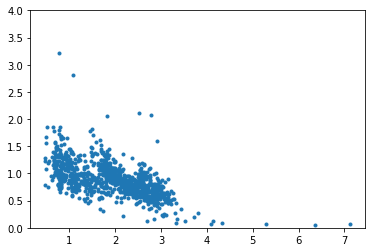

In [24]:
plt.plot(df10['E_ex_t']/df10['E_s_t'],df10['dE_ic'],'.')
plt.ylim(0,4)

In [25]:
df10['X_Mg_0'].describe()

count    1068.000000
mean        0.016495
std         0.013444
min         0.000010
25%         0.000010
50%         0.010008
75%         0.030004
max         0.040002
Name: X_Mg_0, dtype: float64

In [26]:
# cvals = (df10['T_cmb0']-5000)/1000
cvals = (df10['X_Mg_0'])/.04
colors= plt.cm.rainbow(cvals)

(0, 4)

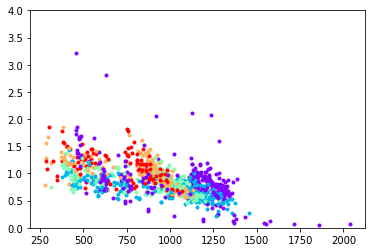

In [27]:
for x,y,c in zip(df10['E_ex_t'],df10['dE_ic'],colors):
    plt.plot(x,y,'.',color=c)

plt.ylim(0,4)

(0, 4)

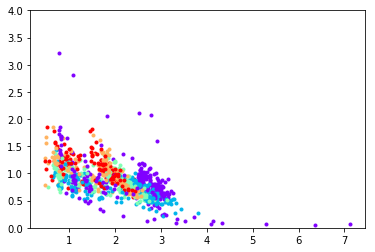

In [28]:
for x,y,c in zip(df10['E_ex_t']/df10['E_s_t'],df10['dE_ic'],colors):
    plt.plot(x,y,'.',color=c)

plt.ylim(0,4)

(0, 5)

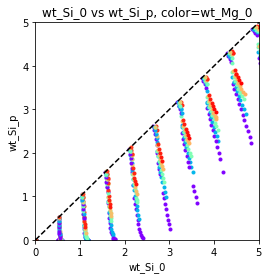

In [29]:
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'
cvar = 'wt_Mg_0'

cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


(0, 5)

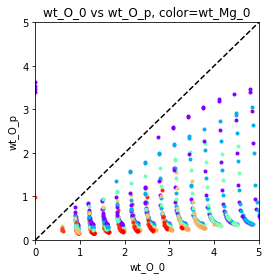

In [30]:
xvar = 'wt_O_0'
yvar = 'wt_O_p'
cvar = 'wt_Mg_0'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


# Initial Constraints (Fischer)

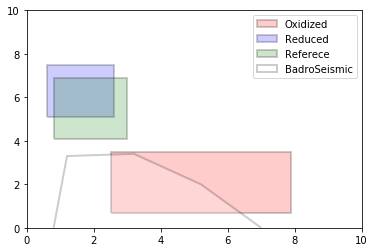

In [35]:
FischerOxidizedPath = mplPath.Path(np.array([(2.5,.7),(2.5,3.5),(7.9,3.5),(7.9,.7),(2.5,.7)]))
FischerReducedPath = mplPath.Path(np.array([(.6,5.1),(.6,7.5),(2.6,7.5),(2.6,5.1),(.6,5.1)]))
FischerReferencePath = mplPath.Path(np.array([(.8,4.1),(3,4.1),(3,6.9),(.8,6.9),(.8,4.1)]))
BadroSeismicOSiPath = mplPath.Path(np.array([[0.8, 0. ],
       [1.2, 3.3],
       [3.2, 3.4],
       [5.2, 2. ],
       [7. , 0. ]]), None)
plt.figure()
ax = plt.subplot(111)
patch = patches.PathPatch(FischerOxidizedPath, lw=2., facecolor='red',alpha=.2,label='Oxidized')
ax.add_patch(patch)
patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece')
ax.add_patch(patch)
patch = patches.PathPatch(BadroSeismicOSiPath, lw=2., facecolor='white', alpha=.2,label='BadroSeismic')
ax.add_patch(patch)
plt.xlim(0,10)
plt.ylim(0,10)
plt.legend()

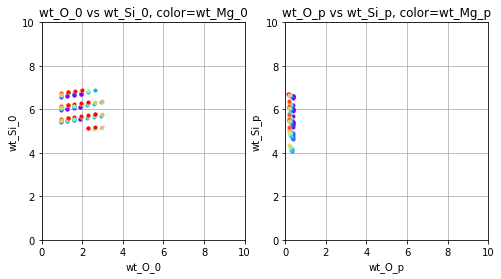

In [36]:
# Initial contraints (Fischer 2015)
df = df10[df10['wt_O_0']<=3]
df = df[df['wt_O_0']>=.8]
df = df[df['wt_Si_0']<=6.9]
df = df[df['wt_Si_0']>=5.1]
df = df[df['T_cmb0']>=5600]

plt.figure(figsize=(8,4))
plt.subplot(121)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
cvar = 'wt_Mg_0'
cvals = (df[cvar])/np.max(df[cvar])
colors= plt.cm.rainbow(cvals)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'.',color=c)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,10)
plt.xlim(0,10)
plt.grid()

plt.subplot(122)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
cvar = 'wt_Mg_p'
cvals = (df[cvar])/np.max(df[cvar])
colors= plt.cm.rainbow(cvals)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'.',color=c)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,10)
plt.xlim(0,10)
plt.grid()

# Oxidized Initial and Final Constraints (Fischer and Badro)

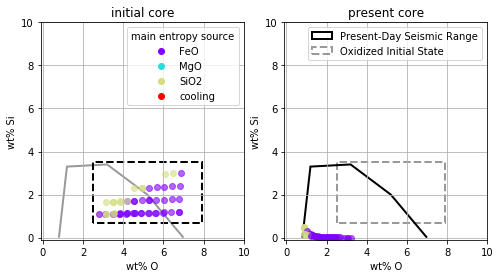

In [37]:
# Present-day constraints (Badro seismic model)
alpha = .6
df = df10
df = df10[df10['wt_O_p']<=7]
df = df[df['wt_O_p']>=.8]
df = df[df['wt_Si_p']<=3.3]
df = df[df['wt_Si_p']>=0.]
# df = df[df['T_cmb0']>=5600]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[df['in_BadroSeismicPresent']==True]
df = df[df['in_FischerOxidizedInitial']==True]


ymax = 10
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
cvar = 'maxE'
cvals = df[cvar].fillna('FeO')
cnames = ['FeO','MgO','SiO2','cooling']
cvalsn = np.array([cnames.index(v)/3 for v in cvals])
colors = plt.cm.rainbow(cvalsn)
colors[df[cvar].isnull()] = (1,1,1,0)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0))
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece')
# ax.add_patch(patch)
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('initial core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()
cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker="o", ls="", mec=None, color=plt.cm.rainbow(cnl[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
plt.legend(handles=lpatchs, title='main entropy source')

ax = plt.subplot(122)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='Present-Day Seismic Range')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0), label='Oxidized Initial State')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced Initial State')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece Initial State')
# ax.add_patch(patch)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()
plt.savefig('Initial_Final_core_composition_Hirose.pdf')

# Reference Initial and Final Constraints (Fischer and Badro)

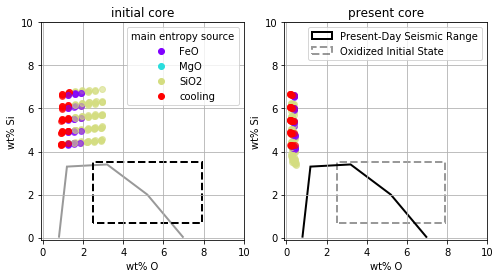

In [55]:
# Present-day constraints (Badro seismic model)
alpha = .6
df = df10
df = df10[df10['wt_O_p']<=10]
# df = df[df['wt_O_p']>=.8]
df = df[df['wt_Si_p']<=10]
df = df[df['wt_Si_p']>=0.]
# df = df[df['T_cmb0']>=5600]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

# df = df[df['in_BadroSeismicPresent']==True]
# df = df[df['in_FischerOxidizedInitial']==True]
df = df[df['in_FischerReferenceInitial']==True]
# df = df[df['in_FischerReducedInitial']==True]


ymax = 10
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
cvar = 'maxE'
cvals = df[cvar].fillna('FeO')
cnames = ['FeO','MgO','SiO2','cooling']
cvalsn = np.array([cnames.index(v)/3 for v in cvals])
colors = plt.cm.rainbow(cvalsn)
colors[df[cvar].isnull()] = (1,1,1,0)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0))
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece')
# ax.add_patch(patch)
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('initial core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()
cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker="o", ls="", mec=None, color=plt.cm.rainbow(cnl[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
plt.legend(handles=lpatchs, title='main entropy source')

ax = plt.subplot(122)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='Present-Day Seismic Range')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0), label='Oxidized Initial State')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced Initial State')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece Initial State')
# ax.add_patch(patch)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()
plt.savefig('Initial_Final_core_composition_HiroseVals_FischerReferenceInit.pdf')

# Reduced Initial and Final Constraints (Fischer and Badro)

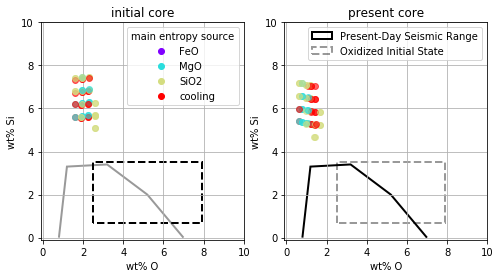

In [375]:
# Present-day constraints (Badro seismic model)
alpha = .6
df = df10
df = df10[df10['wt_O_p']<=10]
# df = df[df['wt_O_p']>=.8]
df = df[df['wt_Si_p']<=10]
df = df[df['wt_Si_p']>=0.]
# df = df[df['T_cmb0']>=5600]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

# df = df[df['in_BadroSeismicPresent']==True]
# df = df[df['in_FischerOxidizedInitial']==True]
# df = df[df['in_FischerReferenceInitial']==True]
df = df[df['in_FischerReducedInitial']==True]


ymax = 10
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
cvar = 'maxE'
cvals = df[cvar].fillna('FeO')
cnames = ['FeO','MgO','SiO2','cooling']
cvalsn = np.array([cnames.index(v)/3 for v in cvals])
colors = plt.cm.rainbow(cvalsn)
colors[df[cvar].isnull()] = (1,1,1,0)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0))
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece')
# ax.add_patch(patch)
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('initial core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()
cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker="o", ls="", mec=None, color=plt.cm.rainbow(cnl[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
plt.legend(handles=lpatchs, title='main entropy source')

ax = plt.subplot(122)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='Present-Day Seismic Range')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0), label='Oxidized Initial State')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced Initial State')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece Initial State')
# ax.add_patch(patch)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()
# plt.savefig('Initial_Final_core_composition.pdf')

# Final Constraints (Badro)

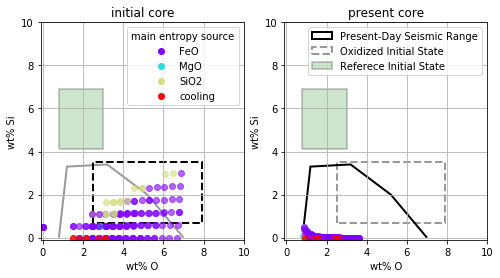

In [56]:
# Present-day constraints (Badro seismic model)
alpha = .6
df = df10
df = df10[df10['wt_O_p']<=10]
# df = df[df['wt_O_p']>=.8]
df = df[df['wt_Si_p']<=10]
df = df[df['wt_Si_p']>=0.]
# df = df[df['T_cmb0']>=5600]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReferenceInitial'] = FischerReferencePath.contains_point((row['wt_O_0'],row['wt_Si_0']))
    df.loc[i,'in_FischerReducedInitial'] = FischerReducedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[df['in_BadroSeismicPresent']==True]
# df = df[df['in_FischerOxidizedInitial']==True]
# df = df[df['in_FischerReferenceInitial']==True]
# df = df[df['in_FischerReducedInitial']==True]


ymax = 10
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
cvar = 'maxE'
cvals = df[cvar].fillna('FeO')
cnames = ['FeO','MgO','SiO2','cooling']
cvalsn = np.array([cnames.index(v)/3 for v in cvals])
colors = plt.cm.rainbow(cvalsn)
colors[df[cvar].isnull()] = (1,1,1,0)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0))
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece')
ax.add_patch(patch)
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('initial core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()
cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker="o", ls="", mec=None, color=plt.cm.rainbow(cnl[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
plt.legend(handles=lpatchs, title='main entropy source')

ax = plt.subplot(122)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='Present-Day Seismic Range')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0), label='Oxidized Initial State')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced Initial State')
# ax.add_patch(patch)
patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece Initial State')
ax.add_patch(patch)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()
plt.savefig('Initial_Final_core_composition_BadroSeismicFinalPlotted.pdf')

(0, 5)

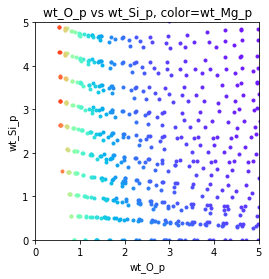

In [251]:
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
cvar = 'wt_Mg_p'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


In [486]:
mpl.colors.cnames

{'aliceblue': '#F0F8FF',
 'antiquewhite': '#FAEBD7',
 'aqua': '#00FFFF',
 'aquamarine': '#7FFFD4',
 'azure': '#F0FFFF',
 'beige': '#F5F5DC',
 'bisque': '#FFE4C4',
 'black': '#000000',
 'blanchedalmond': '#FFEBCD',
 'blue': '#0000FF',
 'blueviolet': '#8A2BE2',
 'brown': '#A52A2A',
 'burlywood': '#DEB887',
 'cadetblue': '#5F9EA0',
 'chartreuse': '#7FFF00',
 'chocolate': '#D2691E',
 'coral': '#FF7F50',
 'cornflowerblue': '#6495ED',
 'cornsilk': '#FFF8DC',
 'crimson': '#DC143C',
 'cyan': '#00FFFF',
 'darkblue': '#00008B',
 'darkcyan': '#008B8B',
 'darkgoldenrod': '#B8860B',
 'darkgray': '#A9A9A9',
 'darkgreen': '#006400',
 'darkgrey': '#A9A9A9',
 'darkkhaki': '#BDB76B',
 'darkmagenta': '#8B008B',
 'darkolivegreen': '#556B2F',
 'darkorange': '#FF8C00',
 'darkorchid': '#9932CC',
 'darkred': '#8B0000',
 'darksalmon': '#E9967A',
 'darkseagreen': '#8FBC8F',
 'darkslateblue': '#483D8B',
 'darkslategray': '#2F4F4F',
 'darkslategrey': '#2F4F4F',
 'darkturquoise': '#00CED1',
 'darkviolet': '#9400D3

In [508]:
mpl.colors.hex2color('#00BFFF')

(0.0, 0.7490196078431373, 1.0)

In [38]:
def get_color(cname):
    cnames = ['FeO','MgO','SiO2','cooling']
    coolcolor = (1,0,0,1)
    scolor = (0.2, 0.6274509803921569, 0.17254901960784313,1)
    fcolor  = (0.7294117647058823, 0.3333333333333333, 0.8274509803921568,1)
    mcolor = (0.0, 0.7490196078431373, 1.0,1)
    colors = [fcolor,mcolor,scolor, coolcolor]
    return colors[cnames.index(cname)]

def maxE_color(df):
    cvals = df[cvar].fillna('FeO')
    colors = np.array([get_color(v) for v in cvals])
    colors[df[cvar].isnull()] = (1,1,1,0)    
    return colors

# Oxidized Initial and Final Constraints (Fischer and Badro)

In [39]:
df = df[df['maxE']=='SiO2']


In [40]:
df['deltawtO'] = df['wt_O_0']-df['wt_O_p']

In [41]:
df['deltawtSi'] = df['wt_Si_0']-df['wt_Si_p']

In [42]:
df['deltawtMg'] = df['wt_Mg_0']-df['wt_Mg_p']

In [43]:
df[['deltawtO','deltawtSi','deltawtMg']].describe()

,deltawtO,deltawtSi,deltawtMg
count,16.000000,16.000000,16.000000
mean,3.125550,1.456716,0.328686
std,1.093349,0.552180,0.367808
min,1.838608,0.848332,-0.000111
25%,2.392074,0.987244,-0.000051
50%,2.725636,1.316410,0.380811
75%,3.753610,1.826828,0.427447
max,5.538396,2.639134,1.214789


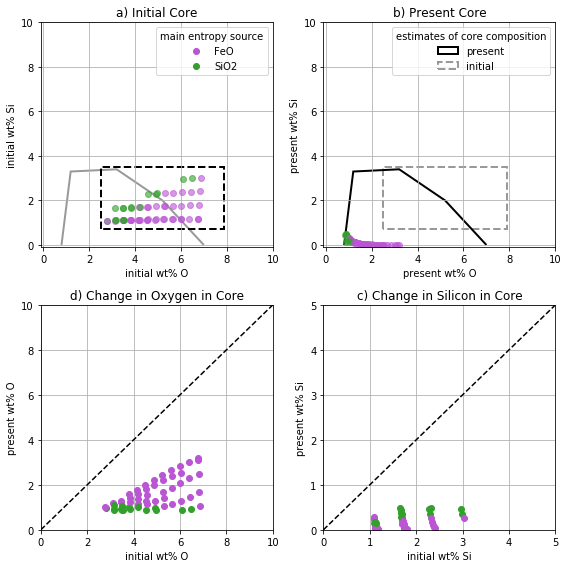

In [53]:
# Present-day constraints (Badro seismic model)
alpha = .6
df = df10
df = df10[df10['wt_O_p']<=7]
df = df[df['wt_O_p']>=.8]
df = df[df['wt_Si_p']<=3.3]
df = df[df['wt_Si_p']>=0.]
# df = df[df['T_cmb0']>=5600]
df = df[df['wt_Mg_0']<=1.5]
for i,row in df.iterrows():
    df.loc[i,'in_BadroSeismicPresent'] = BadroSeismicOSiPath.contains_point((row['wt_O_p'],row['wt_Si_p']))
    df.loc[i,'in_FischerOxidizedInitial'] = FischerOxidizedPath.contains_point((row['wt_O_0'],row['wt_Si_0']))

df = df[df['in_BadroSeismicPresent']==True]
df = df[df['in_FischerOxidizedInitial']==True]


ymax = 10
plt.figure(figsize=(8,8))
ax = plt.subplot(221)
xvar = 'wt_O_0'
yvar = 'wt_Si_0'
# cvar = 'maxE'
# cvals = df[cvar].fillna('FeO')
# cnames = ['FeO','MgO','SiO2','cooling']
# cvalsn = np.array([cnames.index(v)/3 for v in cvals])
# colors = plt.cm.rainbow(cvalsn)
# colors[df[cvar].isnull()] = (1,1,1,0)
colors = maxE_color(df)
# cvar = 'T_cmb0'
# cvar = 'wt_Mg_0'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0))
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,1),fc=(1,1,1,0))
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece')
# ax.add_patch(patch)
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('initial wt% O')
plt.ylabel('initial wt% Si')
plt.title('a) Initial Core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.grid()
cnl = np.array([cnames.index(v)/3 for v in cnames])
lpatchs = [ plt.plot([],[], marker='o', ls="", mec=None, color=get_color(cnames[i]), 
            label="{:s}".format(cnames[i]) )[0]  for i in range(len(cnames)) ]
plt.legend(handles=lpatchs[::2], title='main entropy source')

ax = plt.subplot(222)
xvar = 'wt_O_p'
yvar = 'wt_Si_p'
# cvals = (df[cvar])/np.max(df[cvar])
# colors= plt.cm.rainbow(cvals)
patch = patches.PathPatch(BadroSeismicOSiPath, ls='-', lw=2., ec=(0,0,0,1),fc=(1,1,1,0), label='present')
ax.add_patch(patch)
patch = patches.PathPatch(FischerOxidizedPath, ls='--', lw=2., ec=(0,0,0,.4),fc=(1,1,1,0), label='initial')
ax.add_patch(patch)
# patch = patches.PathPatch(FischerReducedPath, lw=2., facecolor='blue', alpha=.2,label='Reduced Initial State')
# ax.add_patch(patch)
# patch = patches.PathPatch(FischerReferencePath, lw=2., facecolor='green', alpha=.2,label='Referece Initial State')
# ax.add_patch(patch)

for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('present wt% O')
plt.ylabel('present wt% Si')
plt.title('b) Present Core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend(title='estimates of core composition')
plt.grid()


plt.subplot(223)
xvar = 'wt_O_0'
yvar = 'wt_O_p'
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel('initial wt% O')
plt.ylabel('present wt% O')
plt.title('d) Change in Oxygen in Core')
plt.ylim(0,10)
plt.xlim(0,10)
plt.grid()


plt.subplot(224)
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel('initial wt% Si')
plt.ylabel('present wt% Si')
plt.title('c) Change in Silicon in Core')
plt.ylim(0,5)
plt.xlim(0,5)
plt.grid()

plt.tight_layout()
plt.savefig('Core_composition_initfinal_4panel_Oxidized_Hirose.pdf')

In [526]:
np.mean(df['wt_O_0']-df['wt_O_p'])

1.102759724436925

In [527]:
np.mean(df['wt_Si_0']-df['wt_Si_p'])

0.5497767711965014

In [528]:
np.mean(df['wt_Mg_0']-df['wt_Mg_p'])

0.6414105553904517

# Figure 3 Plot for Nature

In [46]:
import matplotlib as mpl
from matplotlib import gridspec
def remove_outliers(t,y,percent=0.3, N=3):
    Nends = N-1
    yo = y + np.mean(y)*.1
#     non_outliers = np.where( np.abs((y[:-Nends]+y[Nends:])/(Nends*y[Nends//2:-Nends//2])-1) < percent)[0]+Nends//2
    non_outliers = np.where( np.abs((yo[:-Nends]+yo[Nends:])/(2*yo[Nends//2:-Nends//2]) - 1) < percent)[0]+Nends//2
    return t[non_outliers], y[non_outliers]

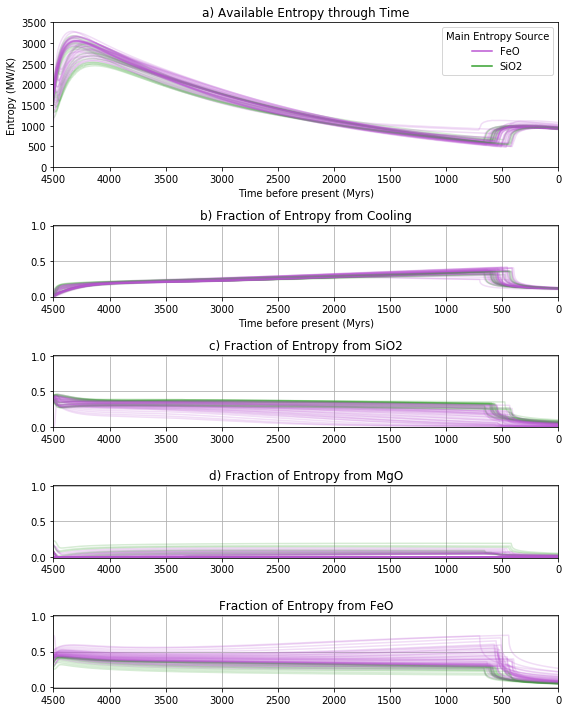

In [54]:
Cent = 1e6
Myrs = 365.25*3600*24*1e6
alpha = 0.2
plt.figure(figsize=(8,10))
gs = gridspec.GridSpec(5, 1,height_ratios=(2,1,1,1,1)) 

ax = plt.subplot(gs[0])
Navg = 3
colors = []
Esifrac = []
Emgfrac = []
Efefrac = []
Ecoolfrac = []
colors = []
tplts = []

for i,row in df.iterrows():
    foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
    if not os.path.exists(datadir+foldername+alldatafile):
        if not os.path.exists(basedir+foldername+solutionfile):
            continue
        pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
        tn, allp = pl.core_layer.compute_all_parameters(times, solution)
        dill.dump((t_N,allp), open(datafolder+foldername+alldatafile,'wb'))
    else:
        tn, allp = dill.load(open(datadir+foldername+alldatafile,'rb'))
    allp.Eex = allp.Egm + allp.Egs + allp.Egf
    allp.Eic = allp.Eg + allp.El
#     cvals = row['maxE'].fillna('FeO')
    cnames = ['FeO','MgO','SiO2','cooling']
    color = get_color(row['maxE'])
#     cvalsn = np.array([cnames.index(v)/3 for v in cvals])
    tn = tn[-1]-tn
    tp,ep = remove_outliers(tn,allp.Ephi,N=5,percent=.02)
    Ct = 3.17e7*1e6
    plt.plot(tp/Ct,ep/1e6, '-',color=color, alpha=alpha)
    tplts.append(tn/Ct)
    Etot = allp.Ephi+allp.Ek
    Esifrac.append(allp.Egs/Etot)
    Emgfrac.append(allp.Egm/Etot)
    Efefrac.append(allp.Egf/Etot)
    Ecoolfrac.append(allp.Es/Etot)
    colors.append(color)

fline = mpl.lines.Line2D([],[],color=get_color('FeO'),label='FeO')
mline = mpl.lines.Line2D([],[],color=get_color('MgO'),label='MgO')
sline = mpl.lines.Line2D([],[],color=get_color('SiO2'),label='SiO2')
coolline = mpl.lines.Line2D([],[],color=get_color('cooling'),label='cooling')

plt.legend(loc='upper right',handles=[fline,sline], title='Main Entropy Source')
plt.ylim(0,3500)
plt.xlim(4500,0)
plt.xlabel('Time before present (Myrs)')
plt.ylabel('Entropy (MW/K)')
plt.title('a) Available Entropy through Time')
# plt.grid()

ax = plt.subplot(gs[1])
for t,e,c in zip(tplts,Ecoolfrac,colors):
#     t,e = remove_outliers(t,e)
    plt.plot(t,e,color=c,alpha=alpha)
plt.ylim(-.01,1.01)
plt.xlim(4500,0)
plt.title('b) Fraction of Entropy from Cooling')
plt.grid()
plt.xlabel('Time before present (Myrs)')

ax = plt.subplot(gs[2])
for t,e,c in zip(tplts,Esifrac,colors):
#     t,e = remove_outliers(t,e)
    plt.plot(t,e,color=c,alpha=alpha)
plt.ylim(-.01,1.01)
plt.xlim(4500,0)
plt.title('c) Fraction of Entropy from SiO2')
plt.grid()
# plt.xlabel('Time before present (Myrs)')

ax = plt.subplot(gs[3])
for t,e,c in zip(tplts,Emgfrac,colors):
#     t,e = remove_outliers(t,e)
    plt.plot(t,e,color=c,alpha=alpha)
plt.ylim(-.01,1.01)
plt.xlim(4500,0)
plt.title('d) Fraction of Entropy from MgO')
plt.grid()
# plt.xlabel('Time before present (Myrs)')

ax = plt.subplot(gs[4])
for t,e,c in zip(tplts,Efefrac,colors):
#     t,e = remove_outliers(t,e)
    plt.plot(t,e,color=c,alpha=alpha)
plt.ylim(-.01,1.01)
plt.xlim(4500,0)
plt.title('Fraction of Entropy from FeO')
plt.grid()

plt.tight_layout()
plt.savefig('figure3_Hirose_SiOMgOcooling.pdf')

# Old Plots

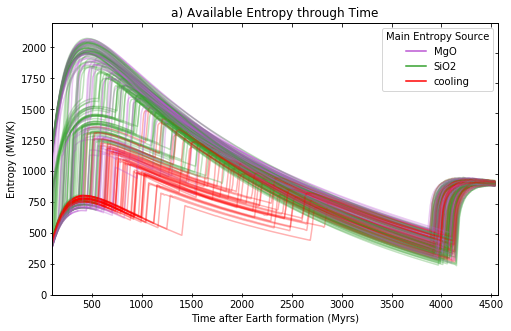

In [500]:
Cent = 1e6
Myrs = 365.25*3600*24*1e6
alpha = 0.3
plt.figure(figsize=(8,5))
gs = gridspec.GridSpec(1, 1) 

ax = plt.subplot(gs[0])
Navg = 3
colors = []
Esifrac = []
Emgfrac = []
Efefrac = []
Ecoolfrac = []
for i,row in df.iterrows():
    foldername = "Tc{:.1f}_XM{:.3f}_XS{:.3f}_XO{:.3f}/".format(row['T_cmb0'],row['X_Mg_0'],row['X_Si_0'],row['X_O_0'])
    if not os.path.exists(datadir+foldername+alldatafile):
        if not os.path.exists(basedir+foldername+solutionfile):
            continue
        pl, times, solution = dill.load(open(basedir+foldername+solutionfile,'rb'))
        tp, allp = pl.core_layer.compute_all_parameters(times, solution)
        dill.dump((t_N,allp), open(datafolder+foldername+alldatafile,'wb'))
    else:
        tp, allp = dill.load(open(datadir+foldername+alldatafile,'rb'))
    allp.Eex = allp.Egm + allp.Egs + allp.Egf
    allp.Eic = allp.Eg + allp.El
#     cvals = row['maxE'].fillna('FeO')
    cnames = ['FeO','MgO','SiO2','cooling']
    color = get_color(row['maxE'])
#     cvalsn = np.array([cnames.index(v)/3 for v in cvals])
    tp,ep = remove_outliers(tp,allp.Ephi,N=5,percent=.02)
    Ct = 3.17e7*1e6
    plt.plot(tp/Ct,ep/1e6, '-',color=color, alpha=alpha)
    Esifrac.append(allp.Egs/allp.Ephi)
    Emgfrac.append(allp.Egs/allp.Ephi)
    Efefrac.append(allp.Egs/allp.Ephi)
    Ecoolfrac.append(allp.Egs/allp.Ephi)
    
fline = mpl.lines.Line2D([],[],color=get_color('FeO'),label='FeO')
mline = mpl.lines.Line2D([],[],color=get_color('MgO'),label='MgO')
sline = mpl.lines.Line2D([],[],color=get_color('SiO2'),label='SiO2')
coolline = mpl.lines.Line2D([],[],color=get_color('cooling'),label='cooling')

plt.legend(loc='upper right',handles=[mline,sline,coolline], title='Main Entropy Source')
plt.ylim(0,2200)
plt.xlim(100,4.568e3)
plt.xlabel('Time after Earth formation (Myrs)')
plt.ylabel('Entropy (MW/K)')
plt.title('a) Available Entropy through Time')
axt = ax.twiny()
axr = ax.twinx()
ax.tick_params()
ax.tick_params(bottom=True, left=True, direction='inout')
axt.tick_params(top=True, direction='in')
axr.tick_params(right=True, direction='in')
axt.set_xticklabels([])
axt.set_xticks(ax.get_xticks())
axt.set_xlim(ax.get_xlim())
axr.set_yticklabels([])
axr.set_ylim(ax.get_ylim())
axr.set_yticks(ax.get_yticks())

(0, 5)

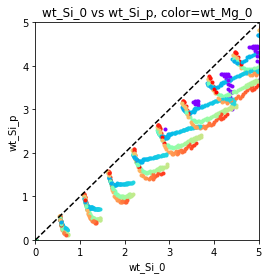

In [301]:
plt.subplot(223)
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'
cvar = 'wt_Mg_0'

cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)

plt.subplot(224)
xvar = 'wt_O_0'
yvar = 'wt_O_p'
cvar = 'wt_Mg_0'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


In [457]:
tn[-1]

1.4392806681479037e+17

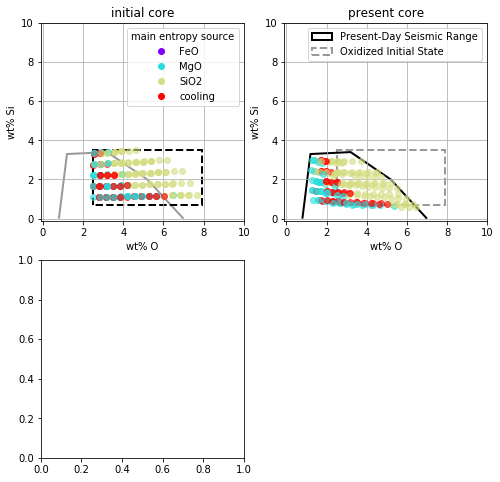

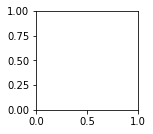

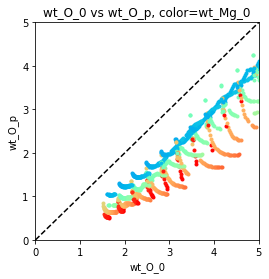

In [377]:
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'o',color=c,alpha=alpha)
# plt.plot([0,10],[0,10],'k--')
plt.xlabel('wt% O')
plt.ylabel('wt% Si')
plt.title('present core')
plt.ylim(-.1,ymax)
plt.xlim(-.1,10)
plt.legend()
plt.grid()

plt.subplot(223)
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'

plt.figure(figsize=(4,4))
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)

plt.subplot(224)
xvar = 'wt_O_0'
yvar = 'wt_O_p'

plt.figure(figsize=(4,4))
for x,y,c in zip(df[xvar],df[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)
plt.savefig('Core_composition_initfinal_4panel_Oxidized_Fischer2015.pdf')

(0, 5)

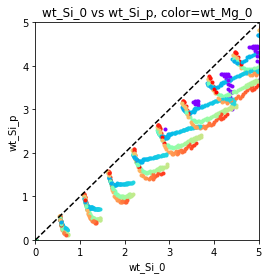

In [301]:
xvar = 'wt_Si_0'
yvar = 'wt_Si_p'
cvar = 'wt_Mg_0'

cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


(0, 5)

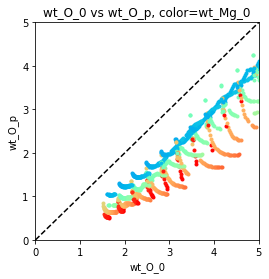

In [302]:
xvar = 'wt_O_0'
yvar = 'wt_O_p'
cvar = 'wt_Mg_0'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)


(0, 5)

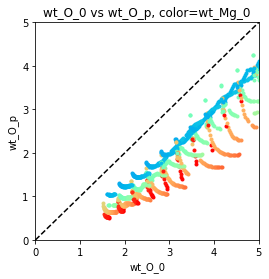

In [302]:
xvar = 'wt_O_0'
yvar = 'wt_O_p'
cvar = 'wt_Mg_0'
cvals = (df10[cvar])/np.max(df10[cvar])
colors= plt.cm.rainbow(cvals)
plt.figure(figsize=(4,4))
for x,y,c in zip(df10[xvar],df10[yvar],colors):
    plt.plot(x,y,'.',color=c)
plt.plot([0,10],[0,10],'k--')
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.title(xvar+' vs '+yvar+', color='+cvar)
plt.ylim(0,5)
plt.xlim(0,5)
